<center><font size = "10"> Week 4 - Ion Channels <center>
<center><font size = "8">Home work SOLUTIONS<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: ELiser Josan Romero

In [46]:
# libraries used
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.optimize import curve_fit


# Ex1. Extracting parameters from experimental data

<font size=3>

You have been provided with a .nwb file describing measurements of a potassium channel.
The Activiation protocol contains current traces for an ion channel voltage clamped at potentials between -90 mV and +80 mV, at 10mV intervals.

Plot each of the traces and inspect them.
For each trace identify the maximum current $I_{max}$ and the activation time constant $ \tau_m $.
You can find $\tau_m$ at each potential value by fitting an exponential function $\displaystyle y = a + b e^{\frac{-x}{\tau_{m}}} $ to the activation curve.
Fit each trace between some start time of your choice (choose carefully) and the point of maximum ionic current.

    
Finally, plot $tau_m$ and $I_k$ against membrane potential (on separate axes). How do they vary with voltage? What does this mean for the behavior of the channel?

[2 pts]



In [47]:
# Open data with python
data_path = 'ion_channel.nwb'

data = h5py.File(data_path, 'r')
print(*data.keys())
print(data['session_description'][0])

acquisition analysis checksums epochs file_create_date general identifier nwb_version processing session_description session_start_time stimulus
b'4 runs with CHO rKv1.6 at 25c.'


In [48]:
list(data['acquisition']['timeseries'].keys())

['AP',
 'Activation',
 'Deactivation',
 'Inactivation',
 'Ramp',
 'Recovery',
 'VRest']

## Plotting activation trace

In [49]:
# setting plotting functions

def plot_timeseries(timeseries_repetition):
    traces = np.array(timeseries_repetition['data']).transpose()
    if 'x_interval' in timeseries_repetition:
        dts = np.array(timeseries_repetition['x_interval'])
    else:
        dts = np.array((len(traces), ))
    fig = plt.figure()
    ax = plt.subplot(111)
    n=1
    for trace, dt in zip(traces, dts):
        time = np.linspace(0, len(trace) * dt, len(trace))
        ax.plot(time, trace, label='trace: %.0f' %(n)) #label=label)
        n+=1
    plt.legend()
    plt.title(timeseries_repetition.name)
    plt.xlabel("Time (s)")
    plt.ylabel("Current (pA)")
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
        

def plot_recurse(group):
    for k, grp in group.items():
        if hasattr(grp, 'items'):
            if 'data' in grp:
                plot_timeseries(grp)
            else:
                plot_recurse(grp)

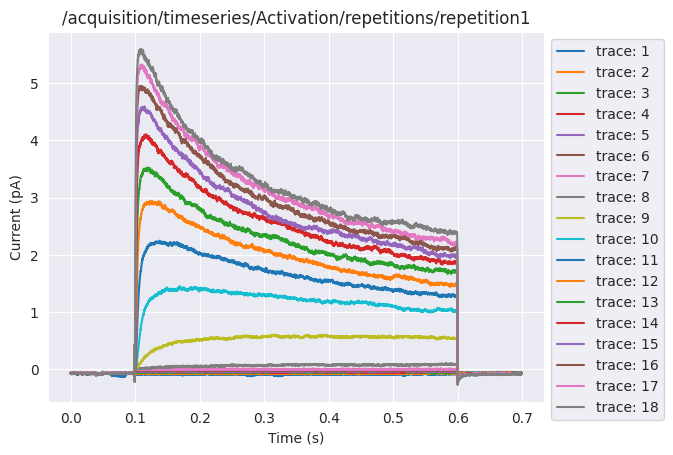

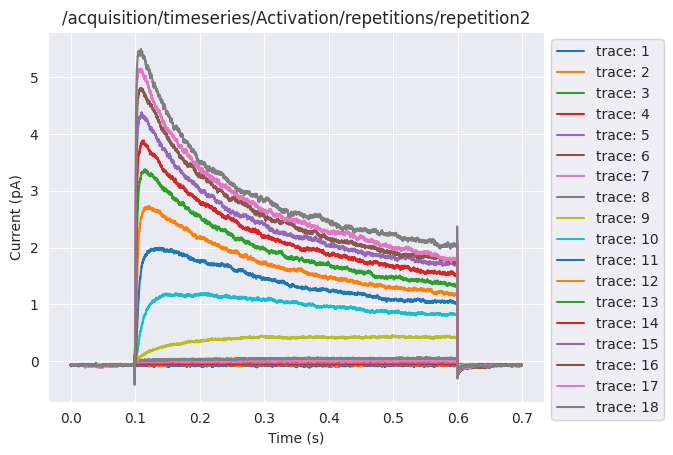

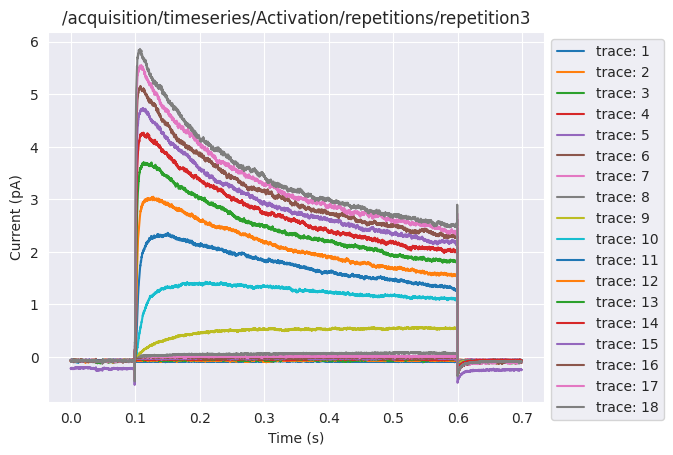

In [50]:
# plot
plot_recurse(data['acquisition']['timeseries']['Activation']['repetitions'])

## Fitting

In [57]:
# looking for directory of data arrays in nwb file
list(data['acquisition']['timeseries']['Activation']['repetitions']['repetition1'].keys())

['amp',
 'capacitance_slow',
 'data',
 'head_temp',
 'n_points',
 'r_series',
 'seal',
 'starting_time',
 'time',
 'trace_ids',
 'trace_times',
 'v_offset',
 'x_interval',
 'x_start']

In [58]:
# checking shape
data['acquisition']['timeseries']['Activation']['repetitions']['repetition1']['data'].shape
# we will need to Transpose

(6990, 18)

In [72]:
def plotDataFiles(data_pathway, pathway, repID):
    ''' Function .....
    :param data_pathway: the data path to file
    :param pathway: the directory within the data file
    :param repID: protocol repetition number
    '''
    
    # Open the file
    open_data = h5py.File(data_pathway, 'r')
    
    # Select on strings what do we want for ploting
    string_data = pathway + str(repID) +'/data'
    string_xinterval = pathway + str(repID) +'/x_interval'
    string_xstart = pathway + str(repID) +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    # each trace in different figures
    data_t = np.transpose(data)
    i = 0
    taus = []
    I_max = []
    for trace in data_t:
         
        def func_exp(x, tau):
            return np.amax(trace[1010:5991])-(np.amax(trace[1010:5991])-trace[1010])*np.exp(-x/tau)
        plt.figure()
        plt.title('%s repetition %s , trace %s' %(pathway, repID,i))
        plt.ylabel('voltage traces (mV)')
        plt.xlabel('time (ms)')
        rank_max = np.argmax(trace[1010:5991])+1010
        plt.plot(time[1010:rank_max], trace[1010:rank_max], 'xk', label='original data')
        popt, pcov = curve_fit(func_exp, np.concatenate(time)[1010:rank_max]-102, trace[1010:rank_max])
        I_max+=[np.amax(trace[1010:5991])]
        taus+=[popt[0]]
        perr = np.sqrt(np.diag(pcov))
        plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
        plt.legend()
        plt.show()

        i += 1
    return taus, I_max

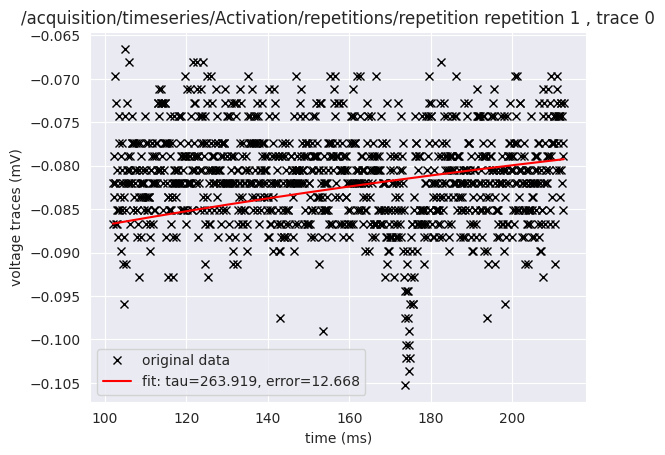

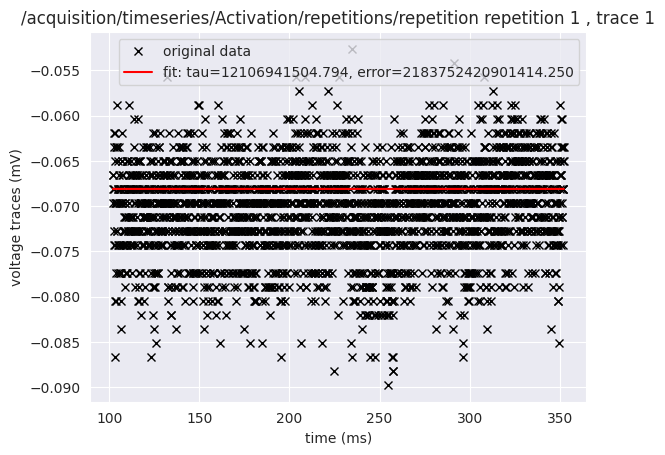

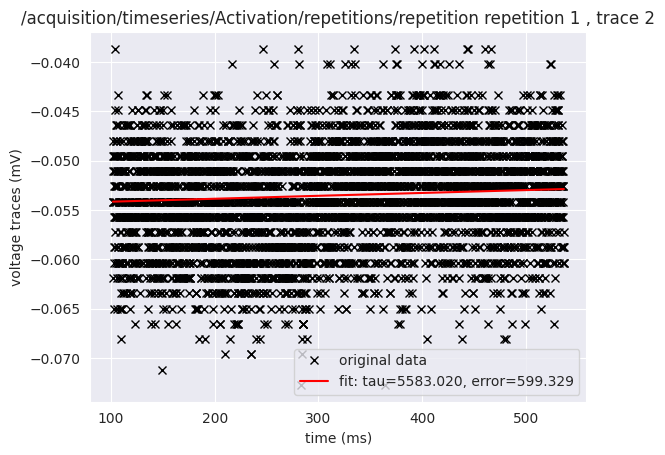

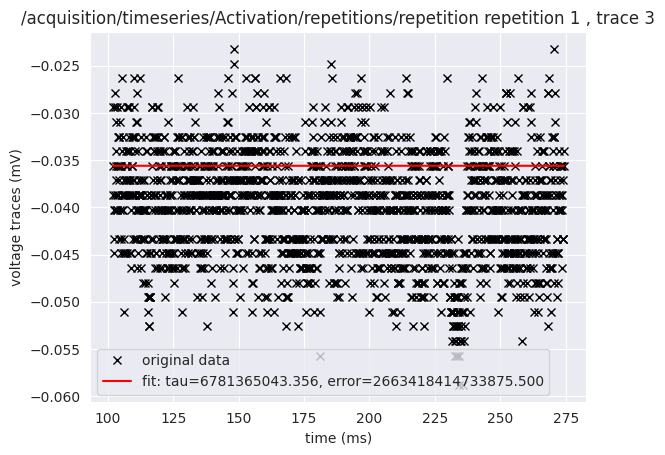

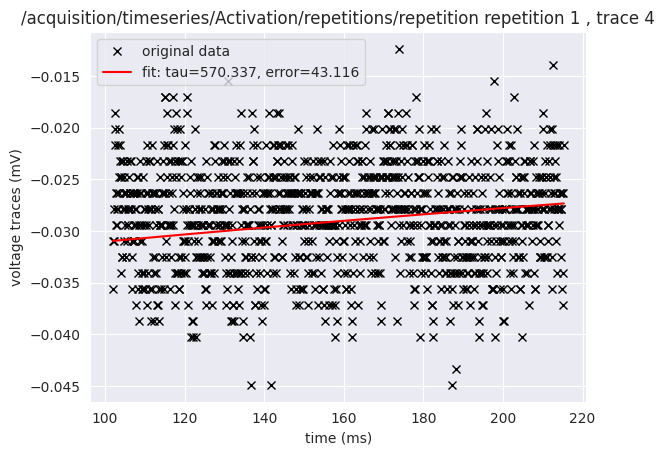

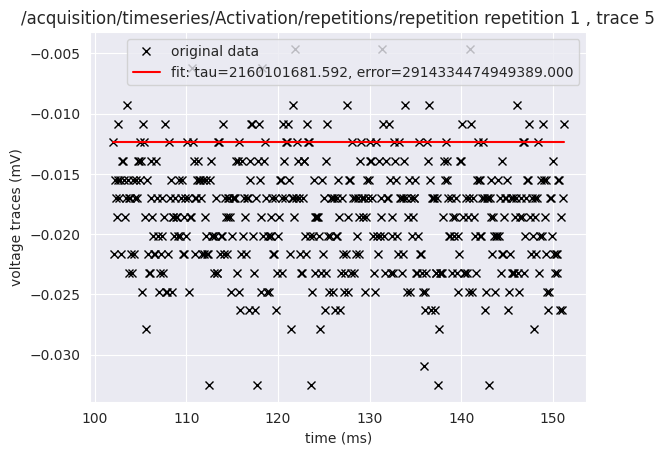

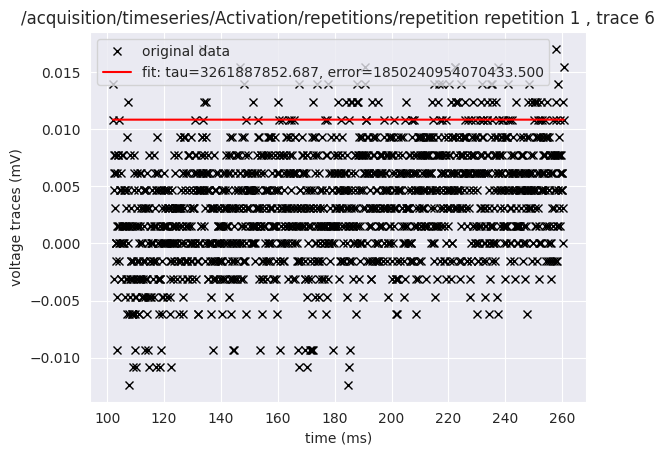

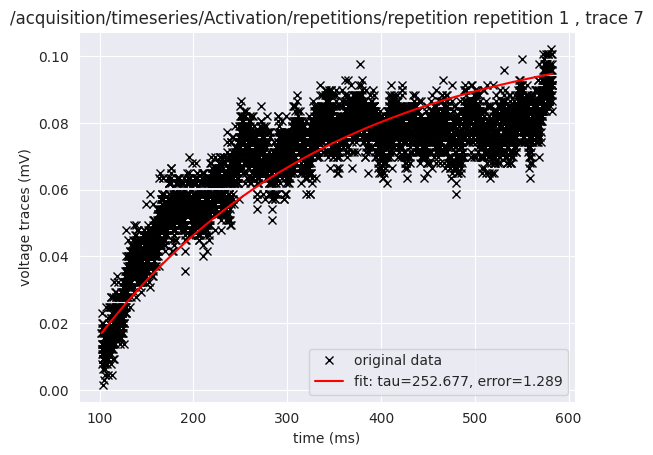

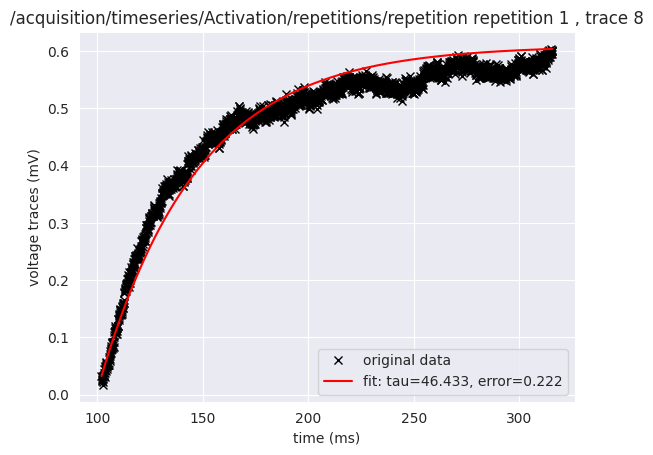

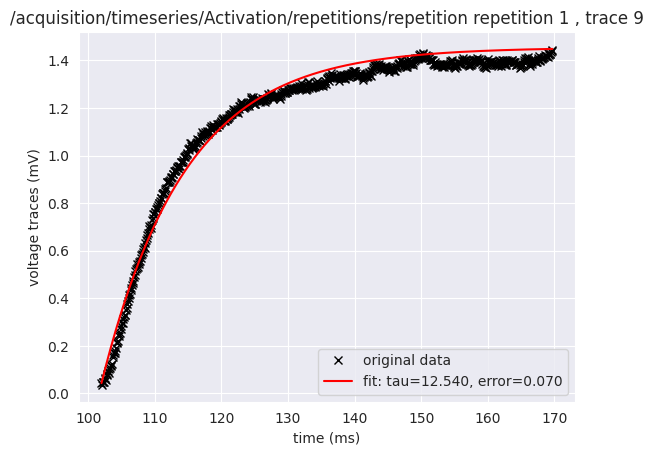

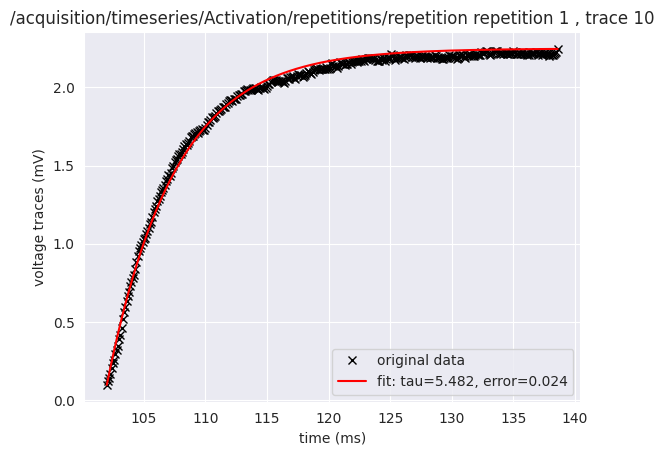

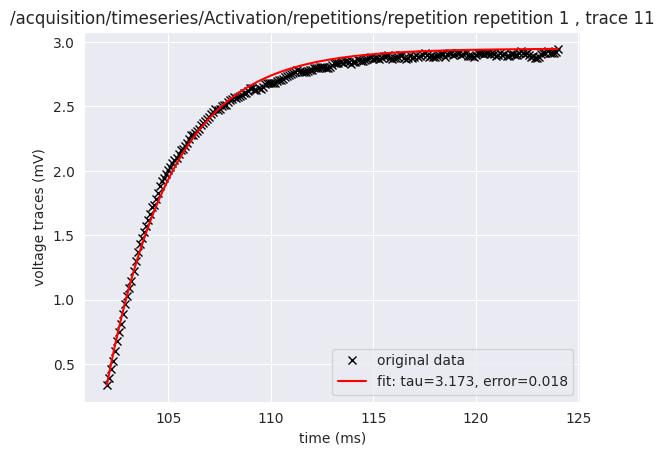

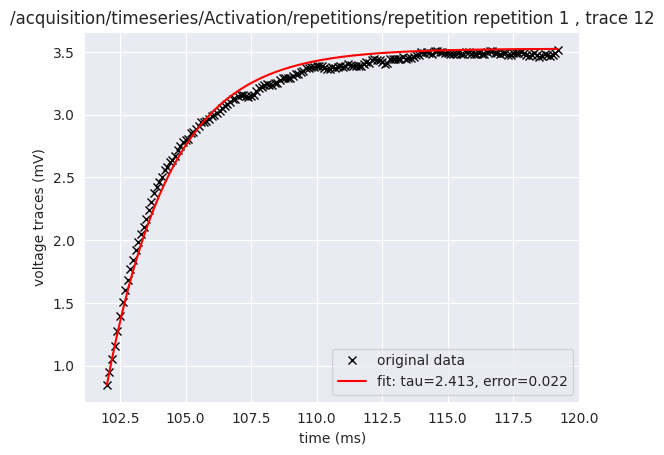

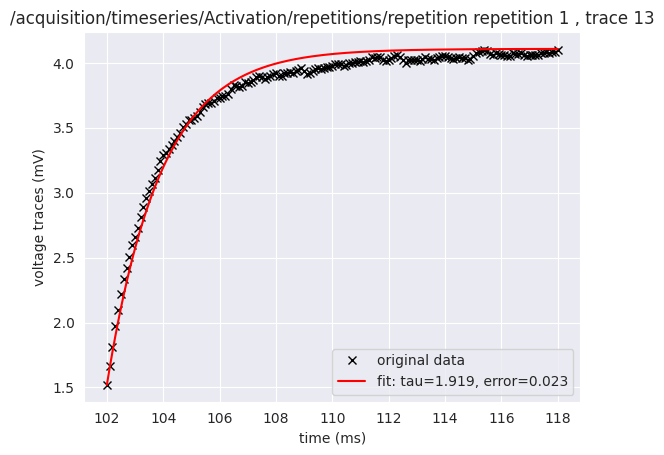

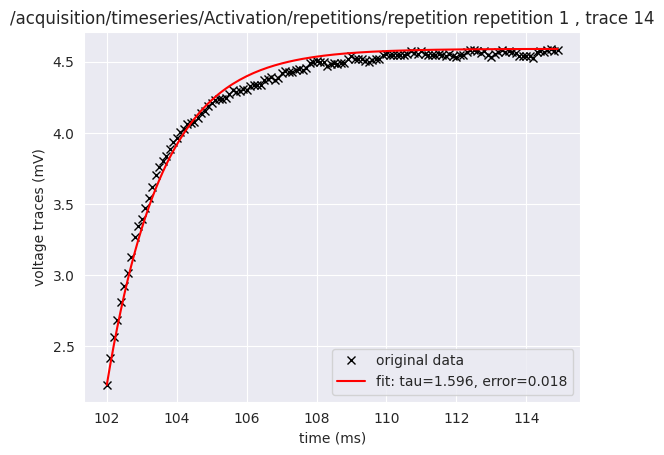

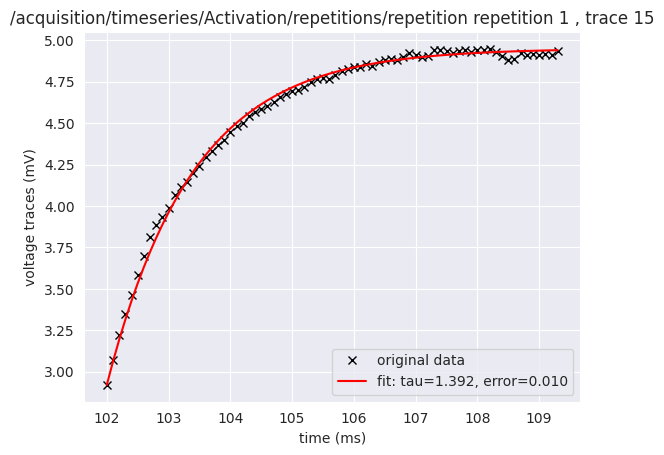

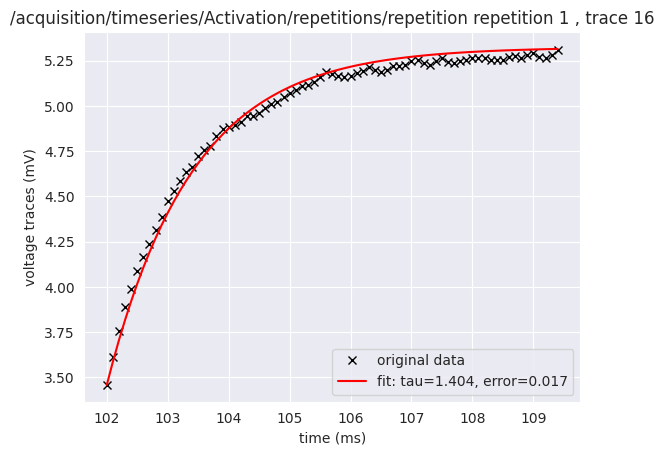

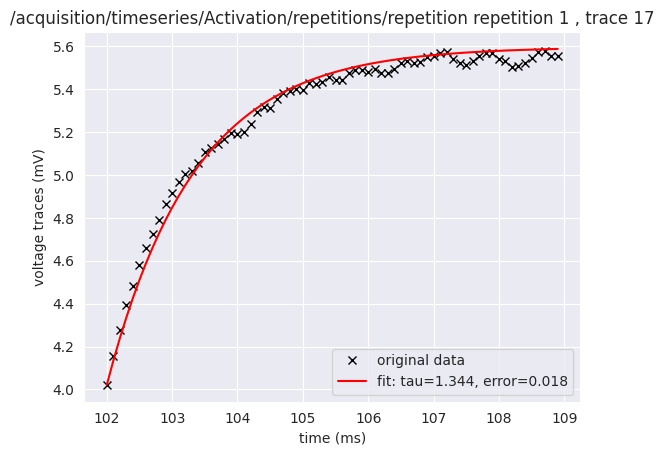

In [73]:
# for repetition 1
pathway = '/acquisition/timeseries/Activation/repetitions/repetition'
repetition = 1
taus, I_k=plotDataFiles(data_path, pathway, repetition)

Finally, plot $tau_m$ and $I_k$ against membrane potential (on separate axes). How do they vary with voltage? What does this mean for the behavior of the channel?

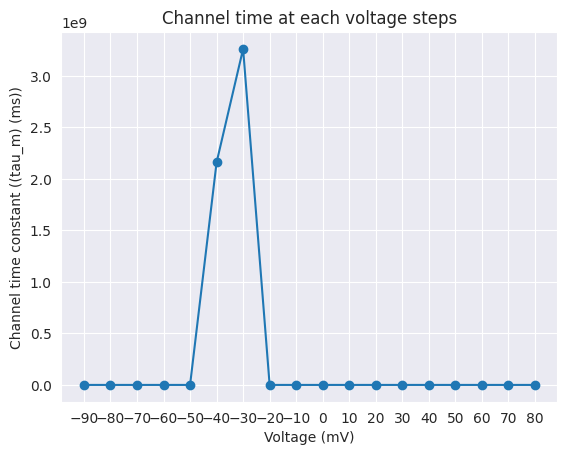

In [74]:
# tau vs voltage
mV = np.linspace(-90,80,18)
# we have to set the first traces to 0 because the plot was too noisy to have an accurate Tau
for i in range (4) :
    taus[i]=0

plt.figure()
plt.plot(mV,taus)
plt.scatter(mV,taus)
plt.title('Channel time at each voltage steps')
plt.ylabel('Channel time constant ((tau_m) (ms))')
plt.xlabel('Voltage (mV)')
plt.xticks(mV)
plt.show()

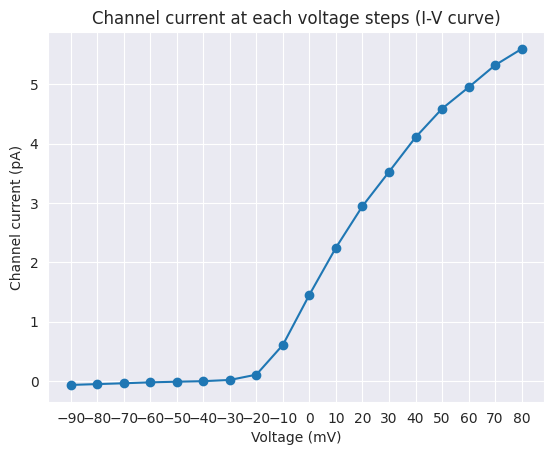

In [75]:
#I_max vs voltage
plt.figure()
plt.plot(mV,I_k)
plt.scatter(mV,I_k)
plt.title('Channel current at each voltage steps (I-V curve)')
plt.ylabel('Channel current (pA)')
plt.xlabel('Voltage (mV)')
plt.xticks(mV)
plt.show()


> As we can see from the plot, the time constant $\tau_m$ decreases with the increase of the membrane potential. This means that the channel opens faster when the membrane potential is higher. The maximum current $I_{max}$ increases with the increase of the membrane potential. This means that the channel is more likely to open when the membrane potential is higher.

# Ex2. Implementing a Potassium channel

<font size=3>

See `SKv3.1.mod`. Your task is to fill it in to implement the following potassium channel model:

$\displaystyle I_K = g_k \times (v - E_k)$
    
Where $I_k$ is potassium current, v is membrane potential, $g_k$ the potassium conductance, and $E_k$ is the reversal potential of potassium (provided for you within the NEURON simulator).

$\displaystyle g_k = \bar{g_k} \times m $
    
Where $\bar{g_k}$ is the maximum potassium conductance and m evolves according to the differential equation:

$\displaystyle m' = \frac{(m_{inf} - m)}{\tau_m}$

$\displaystyle m_{inf} = \frac{1}{1 + e^{\frac{v - v_{half}}{ s_m}}}$
    
$\displaystyle \tau_m = \frac{c_{\tau}}{1 + e^{\frac{v - v_{\tau}}{s_{\tau}}}} $
    
With some values fixed:
    
$s_m = -9.7$
    
$c_{\tau} = 4$
    
$\bar{g_k} = 0.0001 Scm^{-2}$

$v_{\tau} =  -46.560 V$
    
$s_{\tau} = -44$

The remaining parameter, $v_{half}$ we will vary.
    
Next, Create a cell in Neuron with the following characteristics: 
    
 - 1 section (soma) with one segment 15 µm of length and diameter, 
 - 120 Ω*cm of axial radius and 
 - 1.6 µF/cm^2 of capacitance. 
    
Insert the channel you just created.
Add a current clamp stimulus starting at 100ms and lasting 500ms.
    
Vary vhalf for to the values -30, -20, -10, 0, 10, 20. 
For each value of vhalf, vary stimulus amplitude between 0 and 1.5.
Record the maximum membrane potential and potassium conductance for each.
    
plot the I/V curves for each v_half on the same axes. 
explain the meaning of the results.

[2 pts]
    

In [1]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
!nrnivmodl

/home/Week4
Mod files: "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
vhalfs = [-30, -20, -10, 0, 10, 20]

In [17]:
def simulate(vhalf, amplitude=0.04, plot=True):
    # Create a section 
    soma = h.Section()
    soma.L = 15.0     # length (µm)
    soma.diam = 15.0  # diameter (µm)
    soma.Ra = 120.0   # axial resistivity (Ω*cm)
    # soma.nseg = 1
    soma.cm = 1.6

    h.load_file('stdrun.hoc')
    # Insert passive properties

    soma.insert('pas')
    for seg in soma:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

    # INSERT MODELS
    soma.insert('SKv3_1_vhalf')
    for seg in soma:
        seg.gSKv3_1bar_SKv3_1_vhalf = 0.0001  # Maximal conductance of the potassium channels#seg.gKv3bar_K_Ch_vhalf = 12
        seg.vhalf_SKv3_1_vhalf = vhalf


    # Inject a current step into the soma
    stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
    stim.delay = 100   # stim delay (ms)
    stim.amp = amplitude    # stim amplitude (pA)
    stim.dur = 500     # stim duration (ms)

    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)

    # K current
    rec_iK = h.Vector()
    rec_iK.record(stim._ref_i)


    # Initialize and run a simulation
    h.finitialize(-70)    # initial voltage 
    h.continuerun(1000)    # total recording duration

    # PLOT
    # plt.figure(figsize=(20,3))
    # plt.title(f'cell with K channel models vhalf={vhalf}')
    # plt.ylabel('V (mV)')
    # plt.xlabel('t (ms)')
    # plt.plot(rec_t,rec_v, 'b')
    # plt.ylim([-77,-74])
    
    return rec_t, rec_v, rec_iK
    
def simulate_all(vhalf, amplitudes):
    voltages = []
    for a in amplitudes:
        t, v, ik = simulate(vhalf, a, plot=False)
        v = np.array(v)
        max_potential = np.max(v)
        max_conductance = max(ik) / max_potential
        voltages.append(max_potential)
        # print(max_potential, max_conductance)
    return voltages

In [76]:
def simulate_one(vhalf):
    amplitudes = np.linspace(0, 1.5, 10)
    voltages = []
    for a in amplitudes:
        t, v, ik = simulate(vhalf, a, plot=False)
        max_potential = max(v)
        max_conductance = max(ik) / max_potential
        voltages.append(max_potential)
        print(f"Amplitude: {a}, Max potential: {max_potential:.3f}, Max conductance: {max_conductance:.3f}")
    # plt.figure(figsize=(20,3))
    # plt.title(f'cell with K channel model vhalf={vhalf}')
    # plt.ylabel('V (mV)')
    # plt.xlabel('t (ms)')
    # plt.plot(amplitudes,voltages, 'b')

In [77]:
simulate_one(-30)

Amplitude: 0.0, Max potential: -70.000, Max conductance: -0.000
Amplitude: 0.16666666666666666, Max potential: -10.534, Max conductance: -0.016
Amplitude: 0.3333333333333333, Max potential: 46.212, Max conductance: 0.007
Amplitude: 0.5, Max potential: 105.197, Max conductance: 0.005
Amplitude: 0.6666666666666666, Max potential: 164.204, Max conductance: 0.004
Amplitude: 0.8333333333333333, Max potential: 223.201, Max conductance: 0.004
Amplitude: 1.0, Max potential: 282.191, Max conductance: 0.004
Amplitude: 1.1666666666666665, Max potential: 341.177, Max conductance: 0.003
Amplitude: 1.3333333333333333, Max potential: 400.162, Max conductance: 0.003
Amplitude: 1.5, Max potential: 459.146, Max conductance: 0.003


In [78]:
simulate_one(-20)

Amplitude: 0.0, Max potential: -70.000, Max conductance: -0.000
Amplitude: 0.16666666666666666, Max potential: -8.221, Max conductance: -0.020
Amplitude: 0.3333333333333333, Max potential: 46.390, Max conductance: 0.007
Amplitude: 0.5, Max potential: 105.299, Max conductance: 0.005
Amplitude: 0.6666666666666666, Max potential: 164.300, Max conductance: 0.004
Amplitude: 0.8333333333333333, Max potential: 223.294, Max conductance: 0.004
Amplitude: 1.0, Max potential: 282.282, Max conductance: 0.004
Amplitude: 1.1666666666666665, Max potential: 341.267, Max conductance: 0.003
Amplitude: 1.3333333333333333, Max potential: 400.251, Max conductance: 0.003
Amplitude: 1.5, Max potential: 459.235, Max conductance: 0.003


In [79]:
simulate_one(-10)

Amplitude: 0.0, Max potential: -70.000, Max conductance: -0.000
Amplitude: 0.16666666666666666, Max potential: -5.225, Max conductance: -0.032
Amplitude: 0.3333333333333333, Max potential: 46.808, Max conductance: 0.007
Amplitude: 0.5, Max potential: 105.458, Max conductance: 0.005
Amplitude: 0.6666666666666666, Max potential: 164.424, Max conductance: 0.004
Amplitude: 0.8333333333333333, Max potential: 223.403, Max conductance: 0.004
Amplitude: 1.0, Max potential: 282.381, Max conductance: 0.004
Amplitude: 1.1666666666666665, Max potential: 341.360, Max conductance: 0.003
Amplitude: 1.3333333333333333, Max potential: 400.340, Max conductance: 0.003
Amplitude: 1.5, Max potential: 459.321, Max conductance: 0.003


In [80]:
simulate_one(0)

Amplitude: 0.0, Max potential: -70.000, Max conductance: -0.000
Amplitude: 0.16666666666666666, Max potential: -1.904, Max conductance: -0.088
Amplitude: 0.3333333333333333, Max potential: 47.615, Max conductance: 0.007
Amplitude: 0.5, Max potential: 105.695, Max conductance: 0.005
Amplitude: 0.6666666666666666, Max potential: 164.584, Max conductance: 0.004
Amplitude: 0.8333333333333333, Max potential: 223.531, Max conductance: 0.004
Amplitude: 1.0, Max potential: 282.493, Max conductance: 0.004
Amplitude: 1.1666666666666665, Max potential: 341.461, Max conductance: 0.003
Amplitude: 1.3333333333333333, Max potential: 400.433, Max conductance: 0.003
Amplitude: 1.5, Max potential: 459.408, Max conductance: 0.003


In [82]:
simulate_one(10)

Amplitude: 0.0, Max potential: -70.000, Max conductance: -0.000
Amplitude: 0.16666666666666666, Max potential: 1.370, Max conductance: 0.122
Amplitude: 0.3333333333333333, Max potential: 48.965, Max conductance: 0.007
Amplitude: 0.5, Max potential: 106.038, Max conductance: 0.005
Amplitude: 0.6666666666666666, Max potential: 164.787, Max conductance: 0.004
Amplitude: 0.8333333333333333, Max potential: 223.684, Max conductance: 0.004
Amplitude: 1.0, Max potential: 282.619, Max conductance: 0.004
Amplitude: 1.1666666666666665, Max potential: 341.571, Max conductance: 0.003
Amplitude: 1.3333333333333333, Max potential: 400.533, Max conductance: 0.003
Amplitude: 1.5, Max potential: 459.500, Max conductance: 0.003


In [83]:
simulate_one(20)

Amplitude: 0.0, Max potential: -70.000, Max conductance: -0.000
Amplitude: 0.16666666666666666, Max potential: 4.232, Max conductance: 0.039
Amplitude: 0.3333333333333333, Max potential: 50.968, Max conductance: 0.007
Amplitude: 0.5, Max potential: 106.523, Max conductance: 0.005
Amplitude: 0.6666666666666666, Max potential: 165.044, Max conductance: 0.004
Amplitude: 0.8333333333333333, Max potential: 223.865, Max conductance: 0.004
Amplitude: 1.0, Max potential: 282.763, Max conductance: 0.004
Amplitude: 1.1666666666666665, Max potential: 341.693, Max conductance: 0.003
Amplitude: 1.3333333333333333, Max potential: 400.641, Max conductance: 0.003
Amplitude: 1.5, Max potential: 459.599, Max conductance: 0.003


## I-V Experimental curve

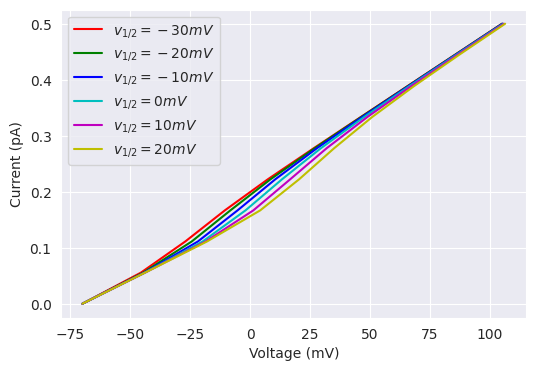

In [86]:
plt.figure(figsize=(6,4))

for v, color in zip(vhalfs, ['r', 'g', 'b', 'c', 'm', 'y']):
    amplitudes = np.linspace(0, 0.5, 10)

    voltages = simulate_all(v, amplitudes)
    plt.xlabel('Voltage (mV)')
    plt.ylabel('Current (pA)')
    plt.plot(voltages,amplitudes, color, label ="$v_{1/2} = " + f"{v} mV$" )
    plt.legend()

## I-V Theoretical curve by changing vhalf

/tmp/ipykernel_302/367174917.py:5: RuntimeWarning: invalid value encountered in log
  vs = vhalf - 9.7 * np.log((1 / is_) - 1)


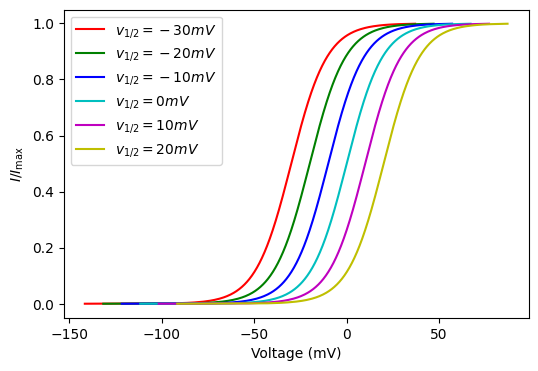

In [44]:
fix, ax = plt.subplots(figsize=(6, 4))

for vhalf, color in zip(vhalfs, ['r', 'g', 'b', 'c', 'm', 'y']):
    is_ = np.linspace(0.00001, 1.5, 1000, endpoint=False)
    vs = vhalf - 9.7 * np.log((1 / is_) - 1)

    ax.plot(vs, is_, color, label="$v_{1/2} = " + f"{vhalf} mV$")

ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('$I/I_{\max}$')
ax.legend()
plt.show()

## Curves explained

The half-maximal activation voltage, often denoted as "vhalf" (V_1/2), represents the membrane potential (V_m) at which ion channels activate to half of their maximum conductance (g_max). This relationship is typically described by the sigmoidal Boltzmann equation:
\begin{equation} 
g(V_m) = \frac{g_{max}}{1 + \exp\left(\frac{-(V_m - V_{1/2})}{k}\right)}
\end{equation} 

When the amplitude of the stimulus is the same, a higher half maximum leads a higher membrane potential. This shows how the greater the half maximum, the more responsive the ion channel is. Once all the ion channels are open, no distinction can be observed among channels with different levels of vhalf. In biology, the current reaches the maximum amplitude (while in our model it grows with the voltage).

# Ex3. Finding the rheobase of a cell

<font size = "3"> 
Create a cell in Neuron with the following characteristics: 
    
 - 1 section (soma) with one segment 15 µm of length and diameter, 
 - 120 Ω*cm of axial radius and 
 - 1.6 µF/cm^2 of capacitance. 

Add active sodium and potassium channels using the hodgekin-huxley (hh) mechanism. Set (gNa = 0.09 S and gK = 0.01 S).
hh also includes a passive conductance driving the neuron to its resting potential.
Set hh.el to -70 mV and hh.gl to 0.003 S/cm^2. 
    
Generate a current clamp experiment in which you inject 0.016 mA current into the cell soma with 50 ms delay, 500ms in duration. Use a voltage base of -70 mV and set the total recording duration of the experiment to 800ms. This is your base experiment - plot the injected current and the resulting membrane potential. Vary the injected current to find the rheobase of this cell - what is its amplitude ? What is the threshold potential for this cell? 

Next, inject the rheobase current into the cell for 60 ms followed 200ms later by double rheobase current for only 30ms. Plot the voltage trace. What do you see? Why does this effect occur?
    
Finally, inject rheobase as in the first experiment but vary the sodium conductance with values 0.08, 0.09, 0.12. Plot the voltage traces. Is the excitability of the cell very sensitive to this parameter? How does this relate to the role of sodium channels in action potential generation?
    
<font size = "3">[2 pt]

In [62]:
from neuron import h

#### First experiment: base experiment

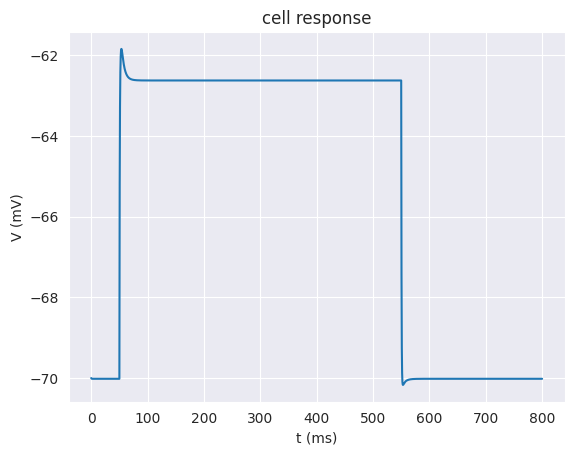

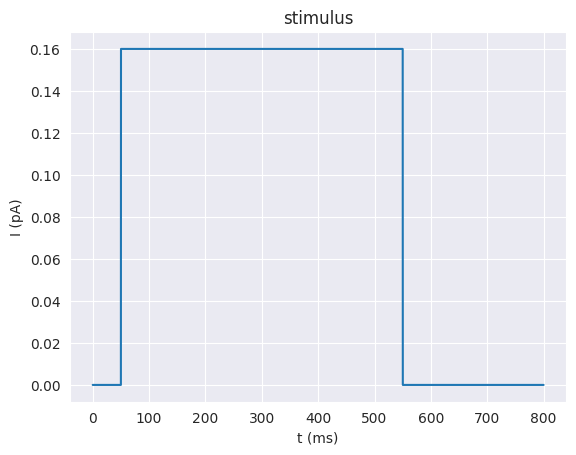

In [64]:
# creating cell
soma = h.Section(name='soma')
soma.L = 15 #µm
soma.diam = 15 #µm
soma.Ra = 120 #Ω*cm
soma.cm = 1.6 #µF/cm^2

# adding properties
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.01   # S 
    seg.hh.gnabar = 0.09  # S
    seg.hh.gl = 0.003 # S/cm^2
    seg.hh.el = -70 # mV
     
# Insert current clamp experiment
stim = h.IClamp(soma(0.5))        
stim.delay = 50   # ms
stim.dur = 500     # ms
stim.amp = 0.16


# Initialize vectors
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)

h.load_file('stdrun.hoc')
h.finitialize(-70)
h.continuerun(800)

plt.figure()
plt.title('cell response')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)
# plt.ylim(top=-69)

plt.figure()
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

#### Second experiment: find rheobase

Rheobase current: 0.22253 pA
Threshold potential: -51.70979 mV


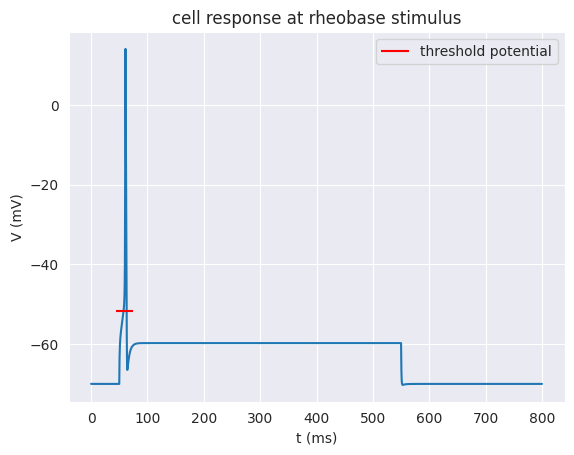

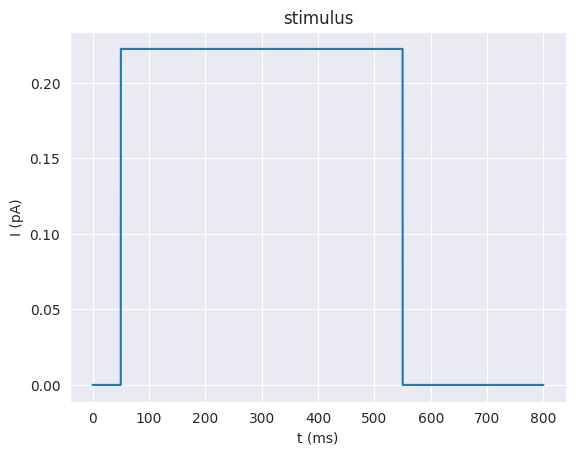

In [65]:
for i in np.linspace(0.22, 0.23, 100): # set through trial and error
    stim.amp = i
    
    # Initialize vectors
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    h.finitialize(-70)
    h.continuerun(800)
    
    # rheobase current found at the first iteration in which the membrane potential exceeds 0 (AP fired)
    cell_v = np.array(rec_v)
    
    if np.any(cell_v>0):
        rheobase = i
        break
    
    # threshold potential is the maximum potential reached at the iteration right before the rheobase one
    thr_time = np.argmax(cell_v)
    thr_pot = cell_v[thr_time]
    thr_ms = thr_time / len(cell_v) *800
    
print("Rheobase current: {:.5f} pA".format(rheobase))
print("Threshold potential: {:.5f} mV".format(thr_pot))

plt.figure()
plt.title('cell response at rheobase stimulus')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)
plt.hlines(thr_pot, thr_ms-15, thr_ms+15, colors='red', label='threshold potential')
plt.legend()

plt.figure()
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

#### Third experiment: two stimuli

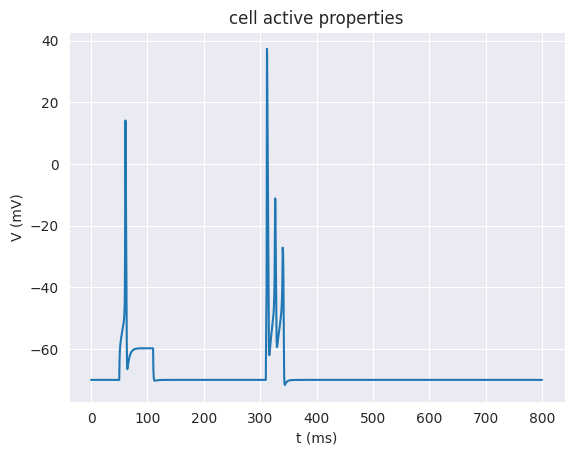

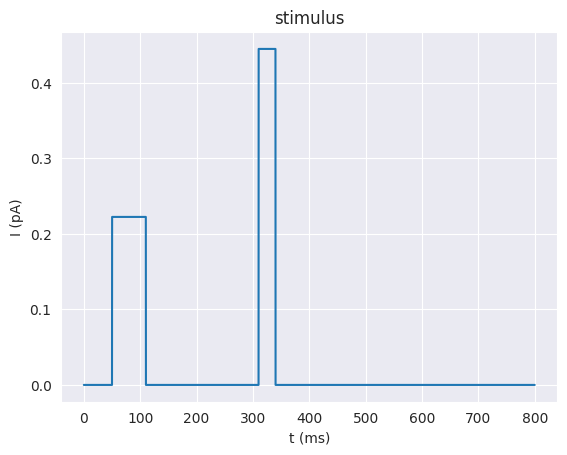

In [66]:
# new stimulation with rheobase current 
stim = h.IClamp(soma(0.5))        
stim.delay = 50   # ms
stim.dur = 60     # ms
stim.amp = rheobase 

stim2 = h.IClamp(soma(0.5))
stim2.delay = 200+50+60
stim2.dur = 30
stim2.amp = rheobase*2

# Initialize vectors
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)
rec_i2 = h.Vector()
rec_i2.record(stim2._ref_i)

h.finitialize(-70)
h.continuerun(800)

plt.figure()
plt.title('cell active properties')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)

plt.figure()
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,np.array(rec_i) + np.array(rec_i2));


The first stimulus lasts long enough to evoke one action potential in the cell.  
The second one, even if of shorter duration, has higher intensity. This causes the cell to fire a burst of three action potentials (firing throught the whole stimulation period).  

In summary, even though the total electric charge is the same in both stimuli, the cell responds in two very different ways depending on its properties. In the second case the depolarization force is stronger, resulting in a burst of action potentials.

#### Fourth experiment: change sodium conductances

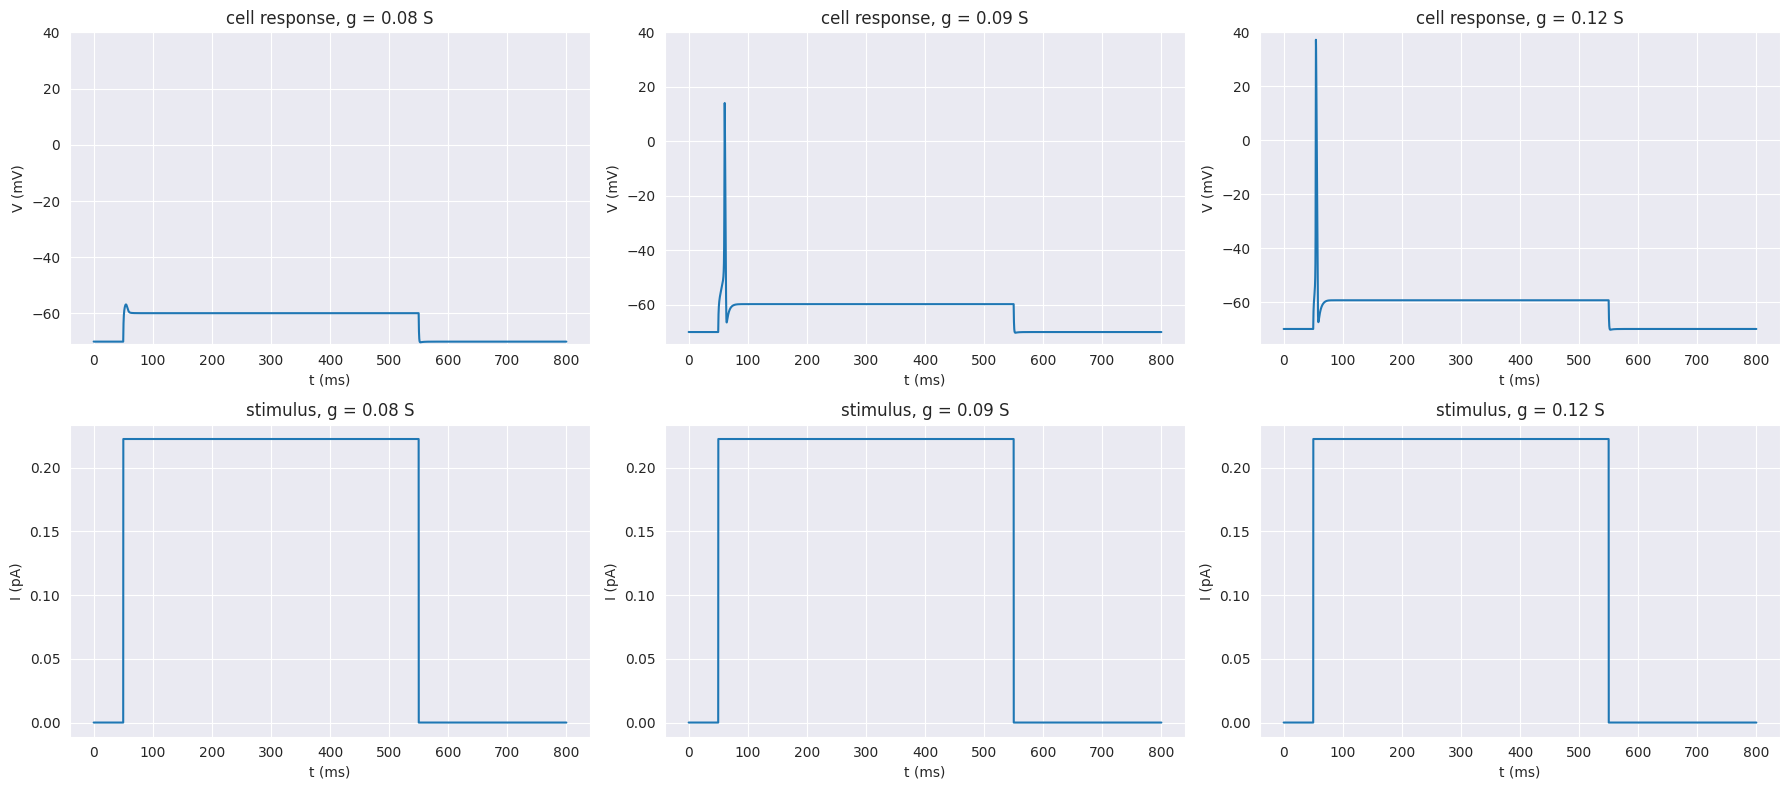

In [67]:
# creating cell
soma = h.Section(name='soma')
soma.L = 15 #µm
soma.diam = 15 #µm
soma.Ra = 120 #Ω*cm
soma.cm = 1.6 #µF/cm^2

# adding properties
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.01   # S 
    seg.hh.gl = 0.003 # S/cm^2
    seg.hh.el = -70 # mV
    
time_vects = []
volt_vects = []
stim_vects = []

conductances = [0.08, 0.09, 0.12]

h.load_file('stdrun.hoc')

    
for cond in conductances:
    for seg in soma:
        seg.hh.gnabar = cond  # S
     
    # Insert current clamp experiment
    stim = h.IClamp(soma(0.5))        
    stim.delay = 50   # ms
    stim.dur =500     # ms
    stim.amp = rheobase   


    # Initialize vectors
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    h.finitialize(-70)
    h.continuerun(800)
    
    time_vects.append(np.array(rec_t))
    volt_vects.append(np.array(rec_v))
    stim_vects.append(np.array(rec_i))
        
    
fig, axs = plt.subplots(2,3, figsize=(18,8))

for i in range(3):
    axs[0][i].plot(time_vects[i], volt_vects[i])
    axs[0][i].set_title("cell response, g = {} S".format(conductances[i]))
    axs[0][i].set_ylabel('V (mV)')
    axs[0][i].set_xlabel('t (ms)')
    axs[0][i].set_ylim(top=40)
    
    axs[1][i].plot(time_vects[i], stim_vects[i])
    axs[1][i].set_title("stimulus, g = {} S".format(conductances[i]))
    axs[1][i].set_ylabel('I (pA)')
    axs[1][i].set_xlabel('t (ms)')

plt.tight_layout()



The cell response is sensitive to changes of sodium channels conductances. Increasing the conductance allows a faster depolarization when the stimulus is presented because more ions can enter the neuron. As a result, the higher the conductance, the stronger the neuron's response.  

In this case, the lowest conductance is not enough to reach the threshold potential at the rheobase current computed for gNA = 0.09S. Instead, the response to the stimulus of the cell with the highest conductance is extremely fast and strong, reaching a very high peak. 

## <font color='green'> Feedback
 
<font size='3'> Ex1: <br>
    - 0.5 point for realising to start from 100ms<br>
    - 0.5 point for finding a good explonential function to fit all data<br>
    - 0.5 points for plotting the traces<br>
    - 0.4 for plotting I_k and tau_m, recognizing that the channel becomes more active and activates more quickly when the cell is depolarized.<br>
    - Your tau_m plot is not very good here, you should have gotten something more in line with your explanation, like below:<br>
    
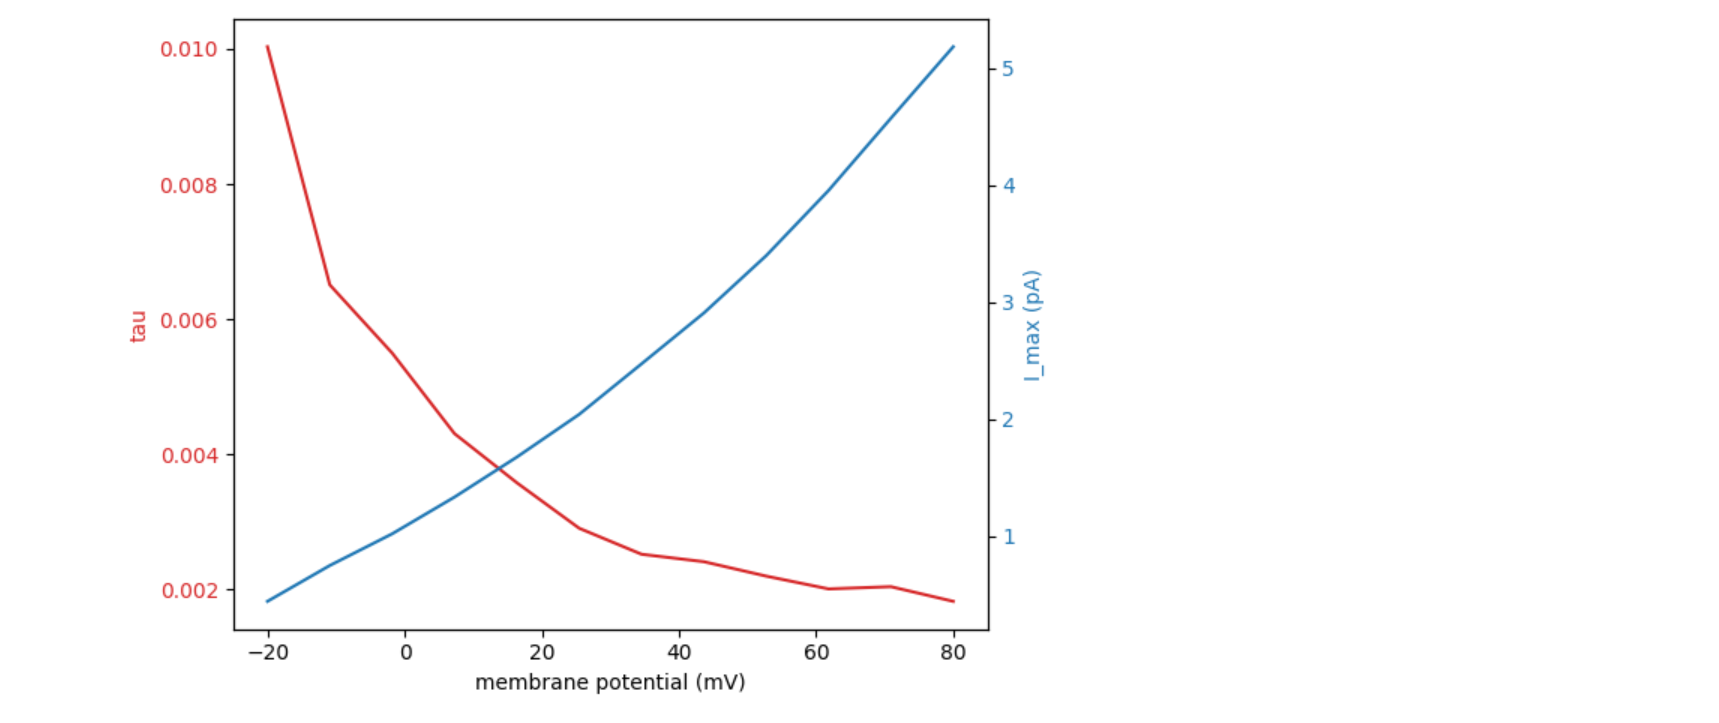
    
<font size='3'> Ex2: <br>
    - 1 pts for entering the correct equations into the modfile<br>
    - 0.5 for correctly plotting I/V curves<br>
    - 0.5 pts for showing that modifying the half-value of the conductance shifts the switch from open to closed to different potentials<br>
    - Note: very good work and explanation! You could add titles to the figures<br>
        
<font size='3'> Ex3: <br>
    - Here you could have plotted things in a clearer way, like below for example. In particular, stimulus and response are usually coupled in graphs<br>

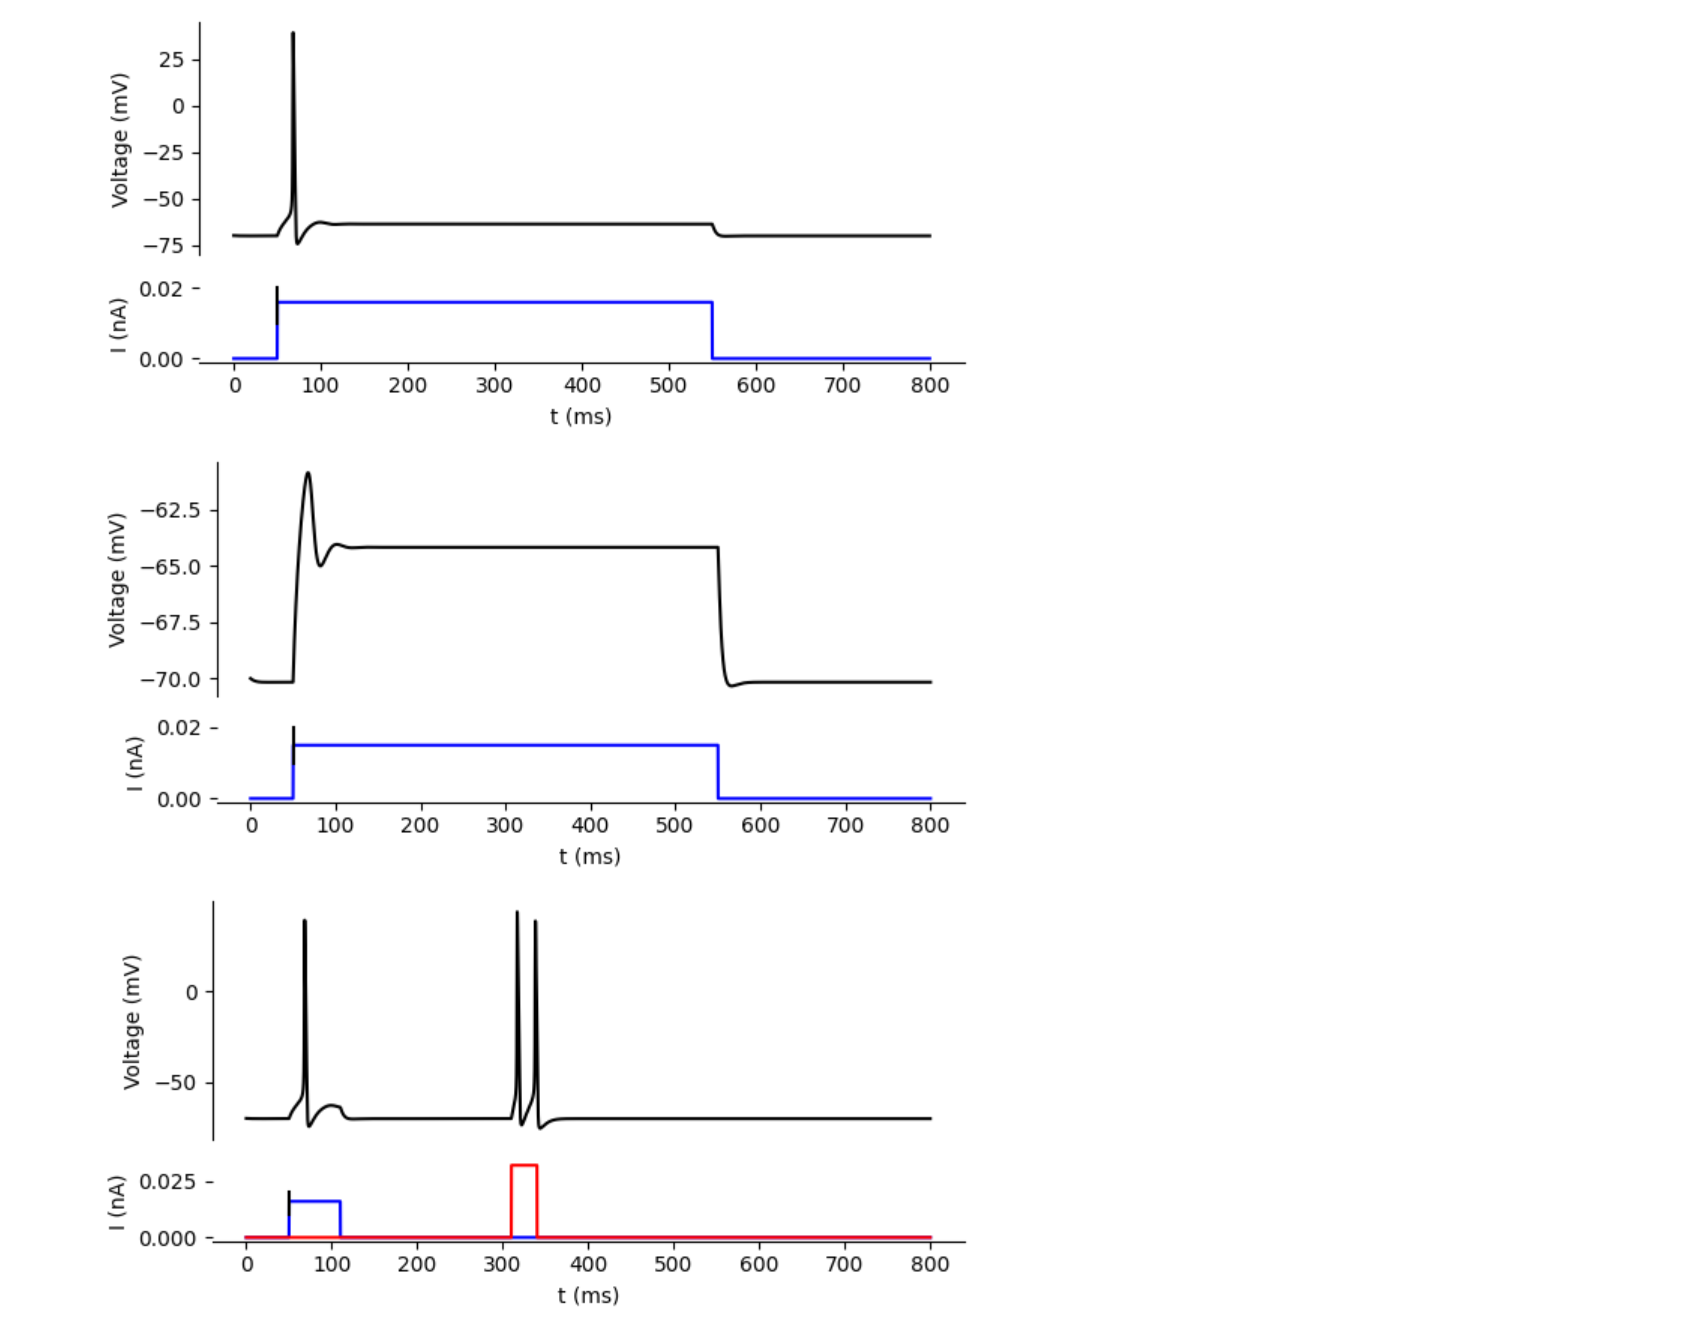
    
    - 0.4 point for setting up base experiment and plotting injected current and voltage reponse with properly labeled axes and units<br>
    - 0.4 point for figuring out and justifying the rheobase of this cell (minimum amount of current required to make the cell fire) and for finding the threshold membrane voltage. You could have been more explicit about the answer and explanation!<br>
    - 0.5 point for discussing how the ease with which a membrane can be stimulated depends on two variables: the strength of the stimulus, and the duration for which the stimulus is applied. A stronger stimulus delivered in a smaller time window tends to cause more spiking, as the membrane leak conductance will have less time remove the injected potential<br>
    - 0.4 point for showing dependence of firing on soldium channels and associating this with the role of sodium channels in the rise phase of the AP
    - In this case you did not rellay see much difference, whereas you should have really seen something like below<br>      
    
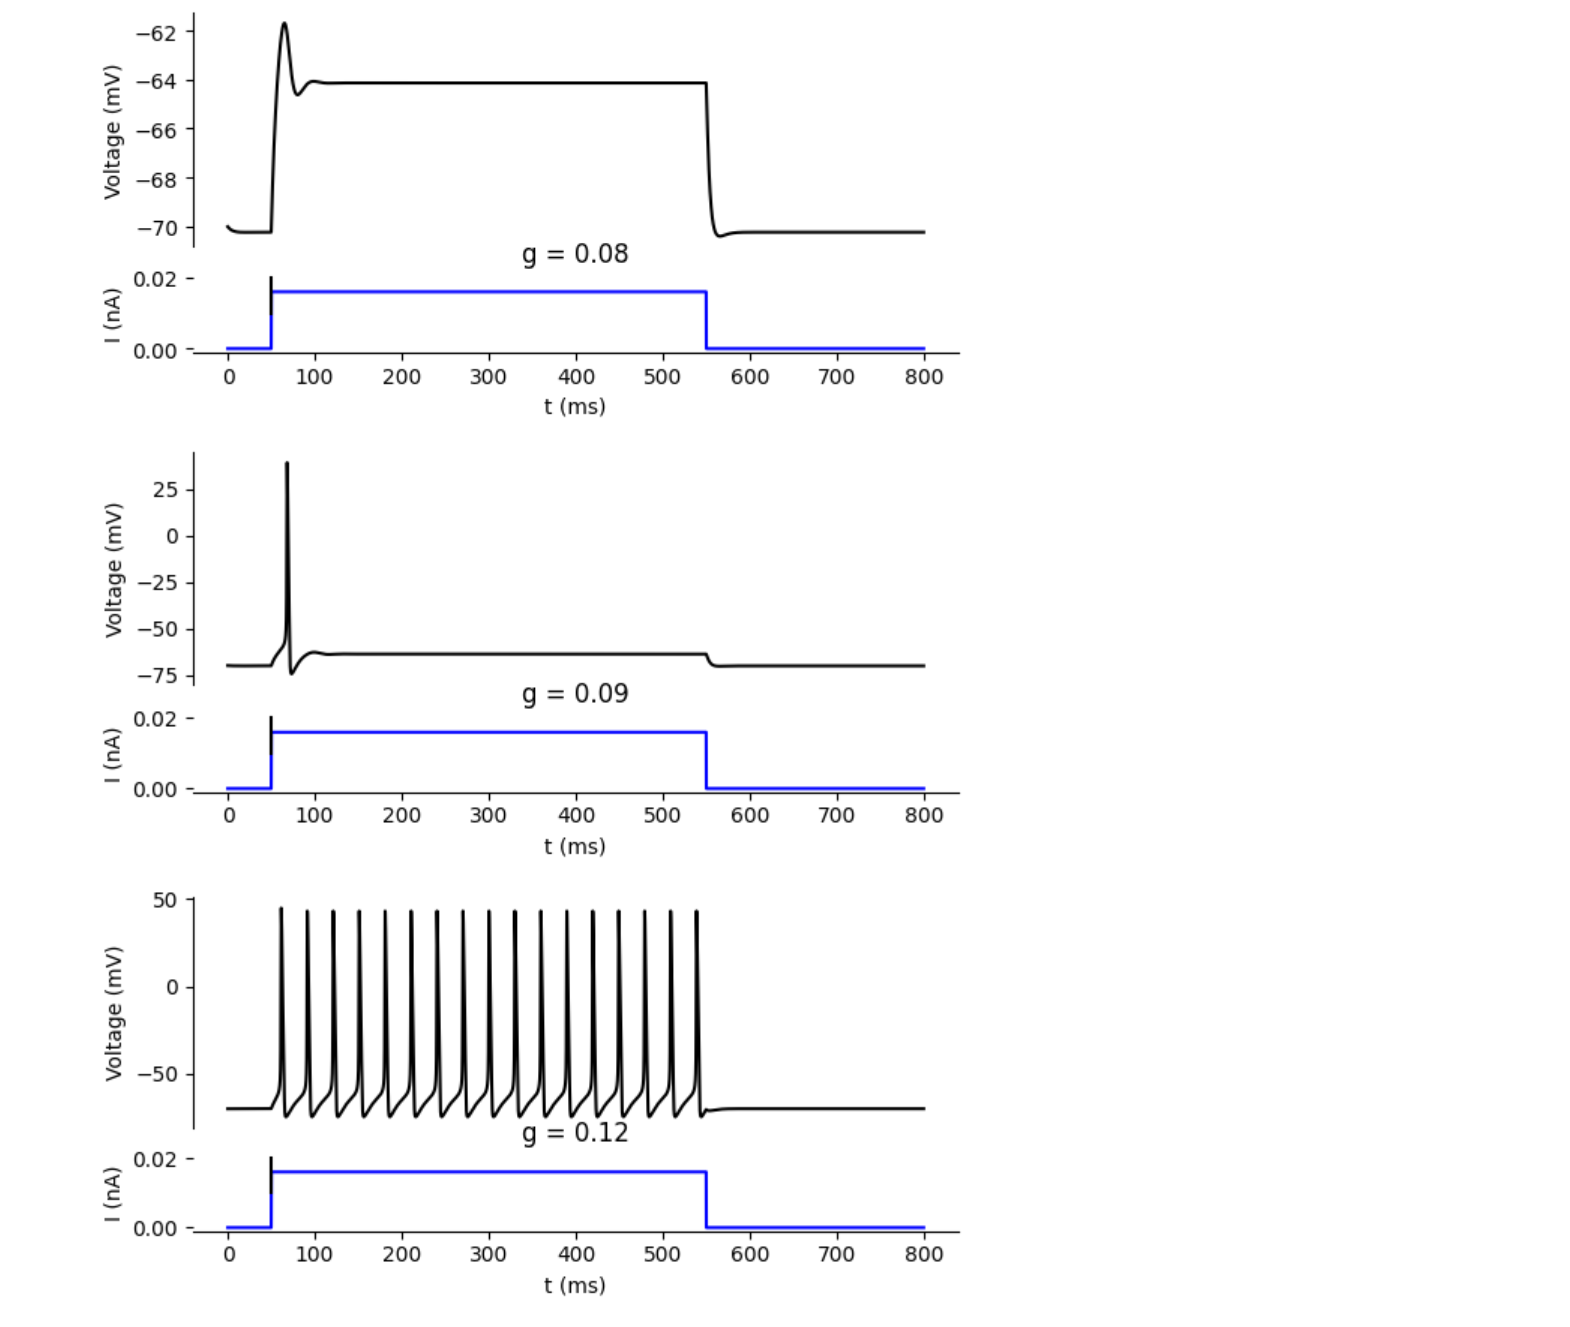
    
<br> <font size='3' color='green'> Overall 5.6 points! Good work!